In [1]:
import torch 
import pickle
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint_adjoint as odeint

In [8]:
# Set the device to GPU since flows are computationally expensive
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [9]:
# Define the ODE function for the time dynamic, i.e., this defines the vector field / differential equation
class ODEFunc(torch.nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 2),
        )
    def forward(self, t, y):
        return self.net(y)

In [10]:
# Load the saved model onto the CPU
ode_func = ODEFunc()
ode_func.load_state_dict(torch.load("best_model_circ.pth", map_location=torch.device('cpu')))
ode_func.eval();

In [11]:
# Generate new samples: samples are newly generated spectra from trained model
# dz_evolution is the evolution of an initial noise vector into the generated spectra
def generate_samples(model, t, n_samples):
    with torch.no_grad():
        base_vecs = torch.normal(mean=0, std=0.1, size=(n_samples, 2))
        dz_evolution = odeint(model, base_vecs, t)
        samples = dz_evolution[-1]
    return dz_evolution, samples

In [12]:
# Define the time grid for solving the initial value ODE, 
# Always between 0 and 1, finer means more accurate but longer training
t = torch.linspace(0.0, 1.0, 100).to(device)

In [17]:
# plot evolution of single noise vector into spectrum
dz_evolution, _ = generate_samples(ode_func, t, 100000)
dz_evolution = np.squeeze(dz_evolution.detach().numpy())
dz_evolution.shape

(100, 100000, 2)

<IPython.core.display.Javascript object>


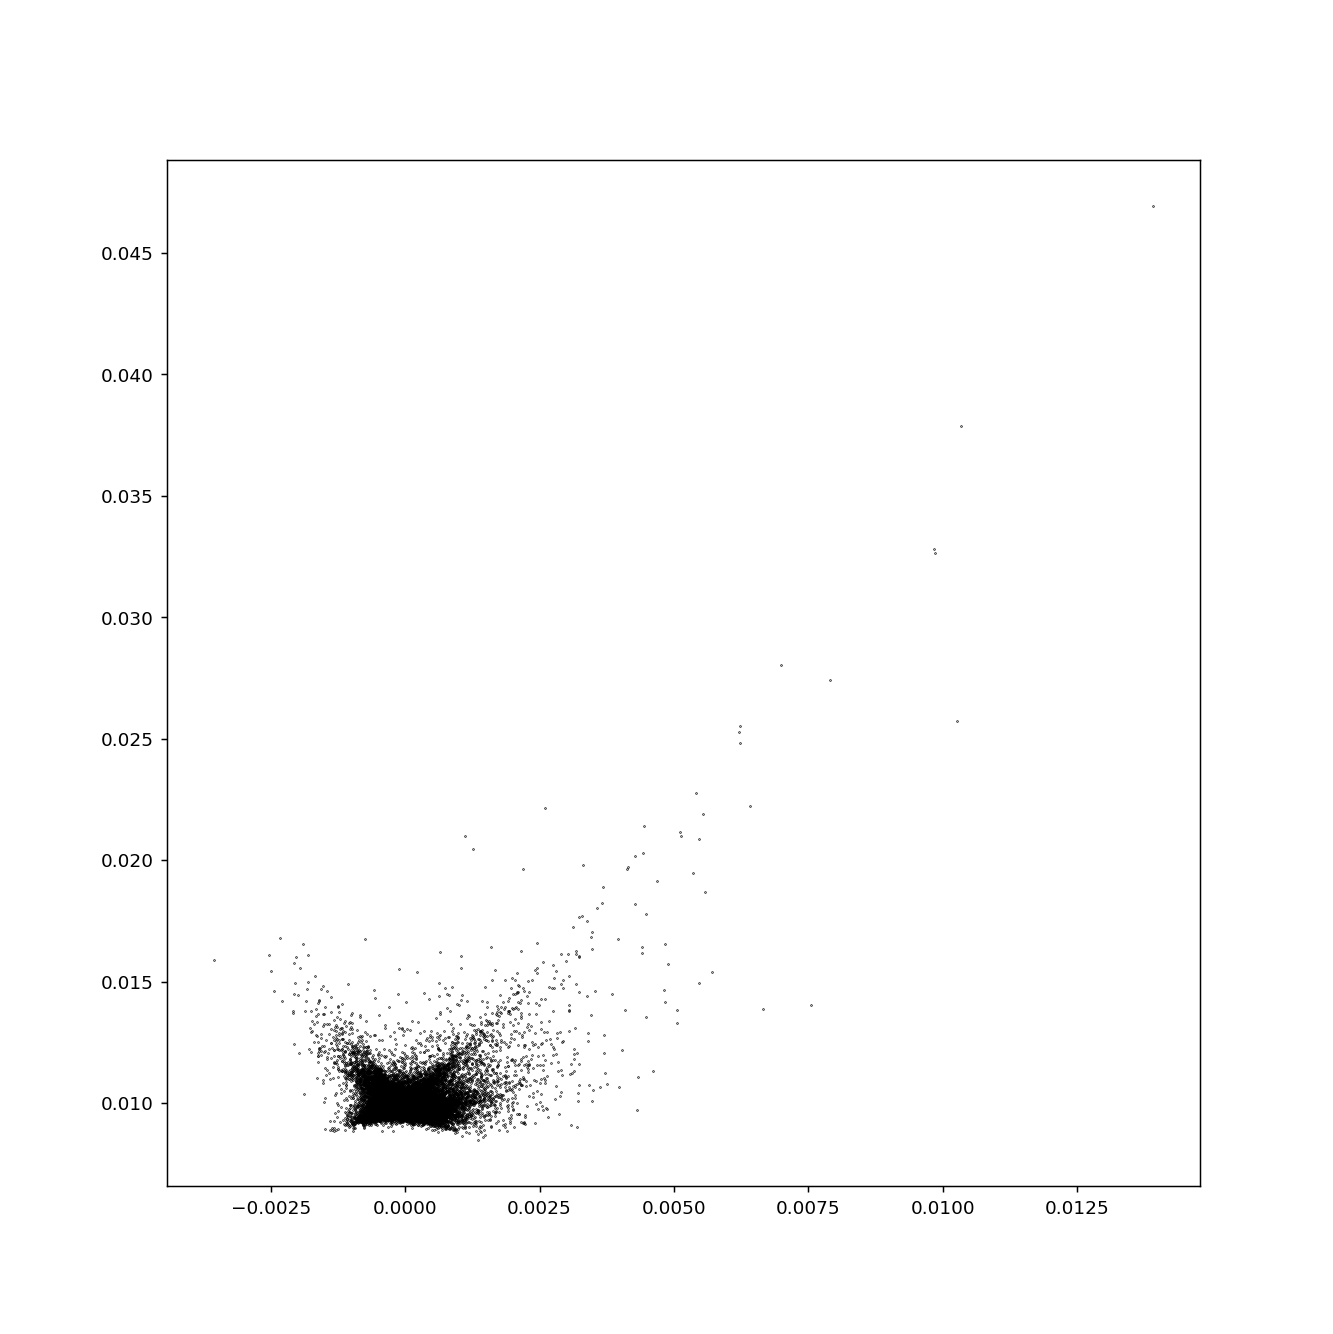

In [21]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# define a function to animate the frames
def animate(i):
    plt.cla()   # clear the previous plot
    data = dz_evolution[i]
    plt.scatter(data[:, 0], data[:, 1], c='k', s=.1)
#     plt.axis('off')

# create the animation
fig = plt.figure(figsize=(10, 10))
ani = animation.FuncAnimation(fig, animate, frames=100, interval=1)

# display the animation in the notebook
plt.show()